# Using undergraduate physics to understand some results in random matrix theory

Comments/questions/errata welcome: [ramasesh@berkeley.edu](mailto:ramasesh@berkeley.edu)

This notebook introduces some concepts from random matrix theory for someone with an undergraduate physics background, specifically basic quantum and statistical physics.  While random matrix theory has roots in physics, and today finds applications everywhere from condensed-matter theory to quantum optics to machine learning, it is typically not taught to physics students in either undergrad or grad school.  Luckily, familiarity with physics makes it easy to understand at least a few interesting ideas in random matrix theory, specifically concerning the so-called *Gaussian orthogonal ensemble* of matrices.  

A lot of this material is drawn from the recent, excellent textbook by Giacomo Livan, Marcel Novaes, and Pierpaolo Vivo: [Introduction to Random Matrices: Theory and Practice](https://www.springer.com/us/book/9783319708836), which is also [available on arXiv](https://arxiv.org/pdf/1712.07903.pdf).  This book seems to be written for people with a physics background and, though conversational, is quite dense as it covers a ton of material.  I certainly had a tough time following some of the arguments.  So, drawing here on some other sources and expanding on the physics connections, I try to make just a few results more accessible to anyone who understands undergrad quantum and stat mech.  If you find this material interesting, the textbook itself is highly recommended.

In [300]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D  

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
%matplotlib inline

## Eigenvalues of random matrices

As the name suggests, *random matrix theory* studies properties of matrices which are themselves random variables.  For example, any time a call is made to, say, `numpy.random.randn()`, to generate an array of real numbers, each of which is normally distributed, a random matrix is generated.  We will be concerned in this notebook with the eigenvalues of random matrices.  That is, given a probability distribution on matrices, what statements can be made about the eigenvalues of such matrices?

Here, generate some random matrices for yourself:

In [215]:
n_rows = 3
n_cols = 4

first_random_matrix = np.random.randn(n_rows, n_cols)
print(first_random_matrix)

[[ 0.53164916 -0.19306377 -0.16845466  0.61513388]
 [ 0.54122704 -0.01799714  0.6807245   0.61410583]
 [ 0.26573356 -1.2674166   0.95357545 -0.43566681]]


Let's specify some matrix ensembles, or probability distributions on matrices, to study.  But first, we must understand how to describe distributions on matrices.  One way is by giving the joint probability distribution for all of the entries of the matrix together.  In general, these distributions are not independent.  However, the ensembles we will study below will have independently-distributed entries.  

For the matrix generated above, the probability distribution is simply a product of standard gaussians, centered at $\mu = 0$ and with a variance of $\sigma^2 = 1$:
\begin{equation}
p_X(\{x_{ij}\}) = \prod_{i,j = 0}^{n_r, n_c} \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{x_{ij}^2}{2\sigma^2}}
\end{equation}

The ensemble of matrices we will study is similar to the above distribution in that is also independently distributes entries according to a Gaussian distribution, but we make two restrictions:
1. **We restrict ourselves to *square* matrices with *real* entries and *real* eigenvalues.**  Recall that, to have real-valued eigenvalues, either the matrix must be symmetric (if the entries are real-valued), or the matrix must be [Hermitian](https://en.wikipedia.org/wiki/Hermitian_matrix) (if the entries are complex-valued).  Here we will focus on real-valued matrices.
2. **We restrict ourselves to probabilty distributions which are invariant to rotations.** For real-valued matrices, a rotation means conjugation by an orthogonal matrix, whereas for a complex-valued matrix, rotation means conjugation by a unitary matrix.  We will show that the probability distribution we are about to introduce respects this invariance. 

### The Gaussian Orthogonal Ensemble (GOE)

The Gaussian orthogonal ensemble is an ensemble of real-valued, symmetric matrices.  Note that the matrices in this ensemble are *NOT* orthogonal!  Rather, this distribution is invariant to conjugation by orthogonal matrices.  Since GOE matrices are symmetric, they are entirely specified by giving the diagonal elements and the elements in the upper triangle.  The GOE probability distribution for the matrix entries $H_{ij}$ is:
\begin{equation}
p_{GOE}(\{H_{ij}\}) =   \begin{cases}
                                   N(0,1) & \text{if $i=j$} \\
                                   N(0,0.5) & \text{if $i\neq j$},
  \end{cases}
\end{equation}
where $N(\mu, \sigma^2)$ describes the normal distribution with mean $\mu$ and variance $\sigma^2$.  That is, the variance of the off-diagonal matrix elements is $0.5$, whereas the variance of the diagonal elements of the matrix is $1$.  This factor of $2$ between the off-diagonal and diagonal variances is what gives the matrix ensemble its rotational invariance (which we will describe below).

One way to generate GOE matrices, which you should convince yourself is equivalent to the distribution given above, is to generate a matrix in which each entry is i.i.d. distributed according to $N(0,1)$, and then symmetrize it.  Let's generate some GOE matrices that way and see what their eigenvalues look like:

In [15]:
def GOE_matrix(dim=3):
    """ generates a matrix of the GOE with specified dimension 'dim' """
    A = np.random.randn(dim, dim)
    return 0.5*(A + A.T)

In [79]:
mat = GOE_matrix(dim=3)
print(f'GOE matrix: \n{mat}')
evals = sorted(np.linalg.eigvals(mat))
print(f'Eigenvalues: {evals}')

GOE matrix: 
[[-2.0084528   0.34011684  0.61513398]
 [ 0.34011684 -0.68155603 -1.33756641]
 [ 0.61513398 -1.33756641 -1.78430192]]
Eigenvalues: [-3.1210038521861314, -1.5688574915624864, 0.21555060124619177]


## 1. Avoided crossings in random matrix spectra

If you play with the above cell a few times, you might notice that the resulting eigenvalues don't seem to get too close to each other.  Let's see this for a variety of different matrix sizes, and compare with randomly generated points.

In [216]:
def generate_GOE_eigenvalues(mat_sizes=[3, 10, 15], n_repetitions=5):

    eigenvalues = {}
    for size in mat_sizes:
        eigenvalues[size] = np.zeros((n_repetitions, size))

    for mat_size in mat_sizes:
        for rep in range(n_repetitions):
            mat = GOE_matrix(dim=mat_size)
            eigenvalues[mat_size][rep] = np.linalg.eigvals(mat)
    
    return eigenvalues

def scatterplot_points(points, title):
    
    n_points_array = points.keys()
    fig, axes = plt.subplots(len(n_points_array), 1, figsize = (5,10), sharex=True)

    for ind, n_points in enumerate(n_points_array):
        for rep in range(points[n_points].shape[0]):
            axes[ind].axhline(rep, zorder = 1)
            axes[ind].scatter(points[n_points][rep], [rep]*n_points, zorder = 2)

        axes[ind].set_frame_on(False)
        axes[ind].set_title(f'{title}: {n_points} points')
        axes[ind].axes.get_yaxis().set_visible(False)
    return fig, axes

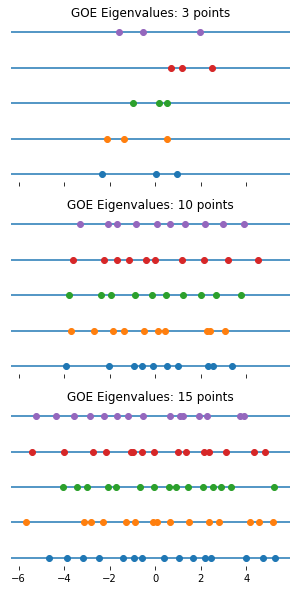

In [217]:
evals = generate_GOE_eigenvalues()
scatterplot_points(evals, 'GOE Eigenvalues');

This sort of behavior might remind you of the phenomenon of *energy-level avoided crossings*, and it in fact turns out that this is essentially the same thing as occuring here with these random matrices. Avoided crossings, which occur in coupled systems, are well-known to students of quantum physics, though they also occur in classical settings (see, for example [this blog post](https://gravityandlevity.wordpress.com/2014/04/08/avoided-crossing/)).  Let's briefly review them here. 

The simplest system in which to see an avoided crossing is a 2-by-2 matrix, say a Hamiltonian describing a two-state system.  Such a system is described by two parameters: the detuning (or energy difference), $2\Delta$, between the two basis states, and the tunneling amplitude, $J$, between these states.  Without loss of generality, we can take the coupling term to be purely real.  Then, in terms of the Pauli matrices
\begin{aligned} \sigma _ { x } & = \left( \begin{array} { c c } { 0 } & { 1 } \\ { 1 } & { 0 } \end{array} \right) \\ \sigma _ { y } & = \left( \begin{array} { c c } { 0 } & { - i } \\ { i } & { 0 } \end{array} \right) \\ \sigma _ { z } & = \left( \begin{array} { c c } { 1 } & { 0 } \\ { 0 } & { - 1 } \end{array} \right), \end{aligned}
we can write the Hamiltonian, $H$, as 
\begin{equation}
H = \Delta \sigma_z + J \sigma_x,
\end{equation}
or 
\begin{equation}
H = \left( \begin{array} { c c } { \Delta } & { J } \\ { J } & { -\Delta } \end{array} \right)
\end{equation}

Now for the avoided crossing:  assume that $\Delta$ is proportional to some external parameter we can control, say, for example, a magnetic field (if we're dealing with a spin-$1/2$ system with a magnetic moment).  As we sweep the magnetic field through zero, what do we see in the spectrum of $H$?  In the absence of the coupling term $J$, the eigenvalues of the spectrum would simply be $\Delta$ and $-\Delta$; in particular, they would become degenerate (cross) at $\Delta = 0$.  However, due to the coupling, *this crossing does not happen*.  One can easily see this by diagonalizing the matrix above analytically **(do it!)**.  For something a bit more visual, let's just plot this spectrum as a function of $\Delta$ and see how it looks.

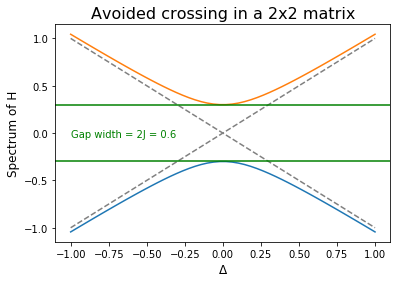

In [196]:
J = 0.3 #change this and see what happens to the gap
Deltas = np.linspace(-1, 1, 50)
evals = np.empty((len(Deltas),2))

for ind, delta in enumerate(Deltas):
    H = np.array([[delta, J],
                  [J, -delta]])
    evals[ind] = sorted(np.linalg.eigvals(H))
    
plt.plot(Deltas, evals);
plt.plot(Deltas, Deltas, ls = '--', c = 'gray')
plt.plot(Deltas, -Deltas, ls = '--', c = 'gray')
plt.xlabel('$\Delta$', size = 12)
plt.ylabel('Spectrum of H', size = 12)
plt.title('Avoided crossing in a 2x2 matrix', size = 16)
plt.axhline(-J, c = 'g')
plt.axhline(J, c = 'g')
plt.text(np.min(Deltas), -0.04, f'Gap width = 2J = {2*J}', color = 'g', size = 10);

Shown in gray are the energies in the absence of the coupling, which exhibit the degeneracy at the zero-crossing of $\Delta$.  However, the coupling $J$ opens up a gap between the two branches, of width $2J$.  This is perhaps the most well-known example of an avoided crossing.  Another commonly-taught example is in basic solid-state physics, in the so-called [nearly free electron picture](https://en.wikipedia.org/wiki/Nearly_free_electron_model).  In this picture, band gaps occur because the periodic lattice couples together free-electron Bloch waves with wavevectors differing by an integer number of reciprocal lattice vectors:



Since avoided crossings are so ubiquitous in physics, it is nice that they show up in the eigenvalue behavior of random matrices.  The [textbook](https://arxiv.org/pdf/1712.07903.pdf) states: 
> This interplay between confinement and repulsion is the physical mechanism at the heart of many results in RMT. 

The mentioned repulsion is simply the avoided crossing we've been discussing, whereas the *confinement* stems from the Gaussian statistics of the diagonal entries: the entries are *confined* to be within a few $\sigma$ of the mean, $\mu = 0$.

### Aside: avoided crossings in the *complex* spectra

Before moving on from the topic of avoided crossings, let's look at something which might not be so familiar to physics students:  avoided crossings also occur in the spectra of matrices with *complex* eigenvalues!

A famous example of this in Random Matrix Theory is the circular law: for Gaussian matrices with independent entries but not necessarily symmetric (i.e. the eigenvalues can be complex), as the size of the matrix grows towards infinity, the eigenvalue distribution (scaled by the square root of the matrix dimension) tends to a uniform distribution on the unit circle (in the complex plane).  However, as in the real-valued case, these complex eigenvalues repel each other!  Take a look below, where we compare the eigenvalues of a large, Gaussian matrix with independent samples from the unit circle.

In [254]:
n_pts = 500

#generate points uniformly on the unit circle
length = np.random.uniform(0, 1, size = n_pts)
angle = np.random.uniform(0, 2*np.pi, size = n_pts)

x_random = np.sqrt(length) * np.cos(angle)
y_random = np.sqrt(length) * np.sin(angle)

#generate eigenvalues of a large matrix
mat = np.random.randn(n_pts, n_pts)
evals = np.linalg.eigvals(mat)/np.sqrt(n_pts)

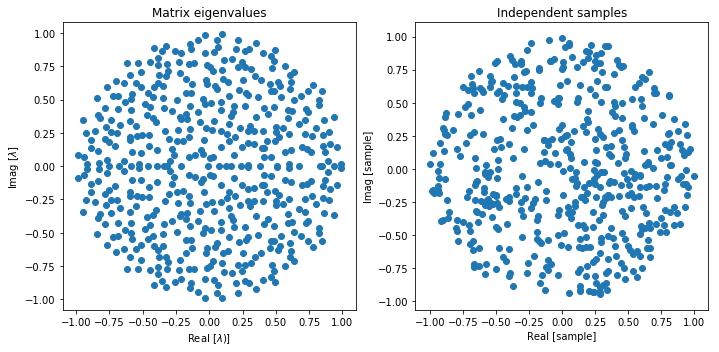

In [255]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex = False, sharey = False, figsize = (10,5))
ax[0].scatter(np.real(evals), np.imag(evals))
ax[0].axis('equal');
ax[0].set_title('Matrix eigenvalues')
ax[0].set_xlabel('Real [$\lambda$)]')
ax[0].set_ylabel('Imag [$\lambda$]')

ax[1].scatter(x_random,y_random)
ax[1].axis('equal');
ax[1].set_title('Independent samples')
ax[1].set_xlabel('Real [sample]')
ax[1].set_ylabel('Imag [sample]')

fig.tight_layout()

Notice how much more clumping there is in the case of independent samples versus matrix eigenvalues.

## 2. Rotational invariance of the GOE

Taking a break from the subject of spectra for a moment, we will show that the GOE is a rotationally-invariant ensemble; that is, the distribution is invariant to conjugation by orthogonal matrices.

The proof just relies on a fact which was learned in first-semester quantum: the trace of a matrix is independent of basis.  In quantum, this meant that conjugation by any unitary operator does not change an operator's trace:
\begin{equation}
\mathrm{Tr}{\left(H\right)} = \mathrm{Tr}{\left(UHU^{\dagger}\right)}
\end{equation}
Since orthogonal matrices are simply a subset of unitary matrices (remember, orthogonal matrices are real-valued and satisfy $OO^T = I$, whereas unitaries satisfy $UU^\dagger = I$), the trace is also invariant to conjugation by orthogonal matrices.

Now let's show that the probability distribution for the GOE can be written in terms of the trace:
\begin{equation}
P_{\mathrm{GOE}}(H) \propto e^{-\sum_i h_{ii}^2/2} e^{-\sum_{i<j} h_{ij}^2}
\end{equation}
The term in the exponential is
\begin{eqnarray}
-\frac{1}{2}\sum_i h_{ii}^2 - \sum_{i<j} h_{ij}^2 &=& -\frac{1}{2}\sum_i h_{ii}^2 - \frac{1}{2}\sum_{i\neq j} h_{ij}^2 \\
&=& -\frac{1}{2}\sum_{i,j} h_{ij}^2 \\
&=& -\frac{1}{2}\sum_{i,j} h_{ij}h_{ji} ~~~ \text{(using symmetry of H)}\\
&=& -\frac{1}{2} \text{Tr}(H^2)
\end{eqnarray}
Thus, $P_{\mathrm{GOE}}(H)$ only depends on the trace of $H^2$, and is thus basis independent. 

A consequence of the rotational invariance is that any orthonormal basis is equally likely to diagonalize a randomly-chosen matrix from the GOE.  We can do some quick numerics to see this in 2D and 3D.  

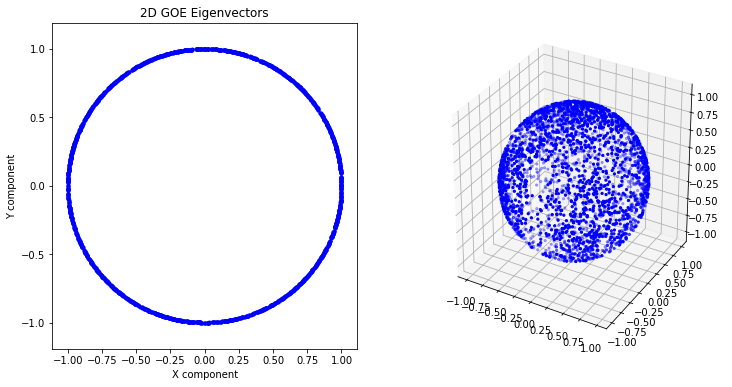

In [321]:
n_repetitions = 500

fig= plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

for _ in range(n_repetitions):
    twodmat = GOE_matrix(dim=2)
    evals, evecs = np.linalg.eig(twodmat)
    ax1.scatter(evecs[:, 0], evecs[:, 1], c='blue', marker='.')
    
    threedmat = GOE_matrix(dim=3)
    evals, evecs = np.linalg.eig(threedmat)
    ax2.scatter(evecs[:, 0], evecs[:, 1], evecs[:, 2], c='blue', marker='.')
ax1.axis('equal');
ax1.set_xlabel('X component')
ax1.set_ylabel('Y component')
ax1.set_title('2D GOE Eigenvectors');

## 3. Wigner's semicircle law

Let's say we generate a bunch of matrices from the $N\times N$ GOE.  A couple things we can ask about the resulting eigenvalues are:
1. What does the joint probability distribution function of the $N$ (real) eigenvalues look like? and 
2. In the limit that $N\rightarrow \infty$, what is the 'density-of-states' of the eigenvalues? 

In this section, we will just state the answer to question 1 (joint pdf), and use it to derive the answer to question 2 (density of states).  While the derivation of the joint pdf is not complicated, it offers no real connection to physics.  If interested, one can find it in chapters 6 and 7 of [the textbook](https://arxiv.org/pdf/1712.07903.pdf). However, the derivation of the density-of-states from the joint pdf does have two nice connections to physics, which we will spend some time on here.

#### A) Joint pdf of GOE eigenvalues

The joint pdf of the $N$ eigenvalues $\{ x_i \}$ is given by
\begin{equation}
\rho \left( x _ { 1 } , \ldots , x _ { N } \right) = \frac { 1 } { \mathcal{Z} _ {N} } e ^ { - \frac { 1 } { 2 } \sum _ { i = 1 } ^ { N } x _ { i } ^ { 2 } } \prod _ { j < k } \left| x _ { j } - x _ { k } \right| 
\end{equation}
Here ${ \mathcal{Z}_N  }$ is a normalizing constant.  In this pdf we can see the competition between confinement and repulsion which was mentioned above:  the first term is the pdf of independent Gaussian random variables, ''confined'' to lie near the origin; whereas the second term reduces the pdf when two eigenvalues get too close to each other, characteristic of avoided crossing or level repulsion.

In terms of this joint pdf, question 2 about the density-of-states is essentially: compute the marginal of the pdf, marginalizing out $N-1$ of the eigenvalues so that only $1$ is left.  Alternatively, one can view it as finding the expectation value of the ''counting funciton'' $n_N(x)$, which counts the fraction of eigenvalues lying in a given interval:
\begin{equation}
n_N(x) = \frac{1}{N}\sum_{i = 1}^N \delta(x - x_i)
\end{equation}
Because the joint pdf above is symmetric under eigenvalue exchange, one can show that the expectation value $\langle n_N(x) \rangle$ against the joint pdf is simply given by the marginalization:
\begin{equation}
\langle n_N(x)\rangle = \rho ( x ) = \int \cdots \int d x _ { 2 } \cdots d x _ { N } \rho \left( x , x _ { 2 } , \ldots , x _ { N } \right)
\end{equation}

While it is possible to derive the marginalization for finite values of $N$, we are interested here in the limiting density as $N\rightarrow\infty$.  This limiting density was derived by Wigner, and is known as Wigner's semicircle law.  Usually, it is written not in terms of the eigenvalue itself, but in terms of the eigenvalue divided by the square root of the system size, that is, $s = x/\sqrt{N}$. As $N\rightarrow\infty$, the marginalization is given by $\rho_{SC}(s)$, where 
\begin{equation}
\rho_{SC}(s) = \frac{1}{\pi}\sqrt{2 - s^2}.
\end{equation}
Clearly this pdf only has support on the interval $|s|<\sqrt{2}$.  


Now for some physics: let's show how it is derived.

### Deriving the Semicircle Law 1: Coulomb gas technique
Let's start out in the derivation by performing the same rescaling as done in the semicircle law: scaling each eigenvalue by the square root of the dimension.  So define $s_i = x_i / \sqrt{N}$, and then 
\begin{equation}
\rho \left( s _ { 1 } , \ldots , s _ { N } \right) = \frac { 1 } { \mathcal{Z'} _ {N} } e ^ { - \frac { N } { 2 } \sum _ { i = 1 } ^ { N } s _ { i } ^ { 2 } } \prod _ { j < k } \left| s _ { j } - s _ { k } \right| 
\end{equation}
The only real change is that there now is a factor of $N$ out front of all the squares in the exponential; the rest of the changes simply get absorbed into a new value of the normalization constant.

Now imagine that instead of being eigenvalues of a random matrix, the values $\{ s_i \}$ were actually positions of (classical) particles living in 1D.  Let's say they're in equilibrium with a bath at some temperature, and pretend that their mass is infinite, or so large that the kinetic energy term is completely neglegible in their (classical) Hamiltonian.  Now, there are two contributions to the potential energy:  a harmonic confining potential $V_H(x)$ that confines all of the particles,
\begin{equation}
V_H(x) = \frac{1}{2}x^2
\end{equation}
and a repulsive force between each pair of particles which scales as $1/r$.  This repulsive force gives a potential energy term of the form $-\ln|r|$ for each pair of particles, 
\begin{equation}
V_{rep}(x_i, x_j) \propto -\ln{|x_i - x_j|}
\end{equation}
where $x_i$ and $x_j$ are the positions of the particles in the pair.  Now all that's left to specify is the relative strength between the repulsive interaction and the confining potential.  We'll take the strength of the repulsive interaction to weaken as the number of particles increases, so the total potential energy term can be written 
\begin{equation}
\mathcal { V } (\{ x_i \}) = \frac { 1 } { 2N} \sum _ { i } x _ { i } ^ { 2 } - \frac { 1 } { 2 N^2 } \sum _ { i \neq j } \ln \left| x _ { i } - x _ { j } \right|
\end{equation}
(Compare eq. (4.3) in the textbook).  Here, the factor of $1/2$ out in front of the natural log prevents overcounting the pairwise repulsive energy.  We will see why the ''extra'' factor of $1/N$ is there in the next section

If we put this system into thermal contact with a reservoir at temperature $T$, i.e. we set up a canonical ensemble, what does the configuration of the system look like?  From statistical mechanics we know that in this situation, the probability of a particular configuration (microstate) $i$ which has energy $E_i$ is given by (setting Boltzmann's constant $k_B = 1$))
\begin{equation}
p(i) = \frac{e^{-E_i/T}}{Z},
\end{equation}
where $Z$, the partition function, is given by 
\begin{equation}
Z = \sum_i e^{-E_i/T}
\end{equation}
So in this case, the probability of finding particles at positions $x_1, ..., x_N$ is
\begin{eqnarray}
p_N(\{ x_i \}|T) &\propto& \exp{\left( - \frac{1}{T} \mathcal { V } (\{ x_i \}) \right) } \\
&\propto& \exp{ \left( - \frac { 1 } { 2NT} \sum _ { i } x _ { i } ^ { 2 } + \frac { 1 } { 2 N^2T } \sum _ { i \neq j } \ln \left| x _ { i } - x _ { j } \right| \right) } \\
&\propto& \exp{\left( - \frac { 1 } { 2NT} \sum _ { i } x _ { i } ^ { 2 } \right) } \exp{ \left(  \frac { 1 } { 2 N^2T } \sum _ { i \neq j } \ln \left| x _ { i } - x _ { j } \right| \right) } \\
&\propto& e^{\left( - \frac { 1 } { 2NT} \sum _ { i } x _ { i } ^ { 2 } \right) } \prod _ { i < j } \left| x _ { i } - x _ { j } \right| ^\frac{1}{N^2T}  \\
\end{eqnarray}
Notice that this looks very similar to the joint pdf we wrote down at the beginning of the section.  In fact, if we put the temperature $T$ as just equal to $1/N^2$, the inverse of the number of particles, then we get the exact same distribution!  This means that to compute the marginal density we were after, we can instead calculate the equilibrium density of particles in our made-up ensemble of particles.  And from statistical mechanics, we know exactly how to calculate the configuration of particles in thermal equilibrium with a thermal reservoir: we minimize the free energy! 

So, we have a route forward: ** we calculate the free energy, $F = -T\ln{Z}$, as a function of the particle density, and find the particle density which minimizes it (at the temperature $T = 1/N^2$; then we take the limit as $N\rightarrow \infty$. **  This is the route taken in chapters 4 and 5 of the textbook, but we will cheat a little bit.  Instead of using the temperature $T = 1/N^2$, we will instead use the fact that $N$ is very large to take the ensemble to be not at *low* temperature, but at *zero* temperature.  This will greatly simplify the calculation, since we know that at at zero temperature, the configuration of a system is simply the one which minimizes the system's energy.  

All we have to do, then, is find the density $n(x)$ such that the potential energy, 
\begin{equation}
\mathcal { V } (\{ x_i \}) = \frac { 1 } { 2N} \sum _ { i } x _ { i } ^ { 2 } - \frac { 1 } { 2 N^2 } \sum _ { i \neq j } \ln \left| x _ { i } - x _ { j } \right|,
\end{equation}
is minimized.  Let's do it!

#### Minimizing the energy 
First step: convert the potential energy $\mathcal{V}(\{ x_i \})$, which currently is a function of the positions of $N$ particles, into a function of a continuous density $n(x)$ of particles.  This is something we do in physics all the time; we simply recognize each term in the potential energy above as an expectation value.  That is, we effectively have 
\begin{equation}
\mathcal { V } (\{ x_i \}) = \frac { 1 } { 2} \langle x^2 \rangle - \frac { 1 } { 2 } \langle \ln \left| x _ { i } - x _ { j } \right|\rangle
\end{equation}
Now writing this in terms of a single-particle density function $n(x)$ gives (we might as well get rid of the $1/2$ since we're just minimizing)
\begin{equation}
\mathcal { V} ( n(x) ) = \int x^2 n(x) dx - \int dx_1 \int dx_2 \ln \left| x_1 - x_2 \right| n(x_1) n(x_2)
\end{equation}
And we want to minimize this functional of $n(x)$, subject to the constraint that 
\begin{equation}
g(n(x)) = \int n(x) dx = 1
\end{equation}
This is now just a calculus-of-variations problem, which you've likely seen many times in a classical mechanics course. As usual in constrained minimization problems over several variables, we'll use a [Lagrange multiplier](https://en.wikipedia.org/wiki/Lagrange_multiplier) to enforce the constraint.  That is, at the minimizing density $n^*(x)$, the variation of $V(n)$ is proportional to the variation of the constraint $g(n)$:
\begin{equation}
\delta V(n(x)) - \lambda \delta g(n(x)) = 0.
\end{equation}
Calculating each term independently, using a small perturbation $\alpha(x)$ (and keeping terms only to first-order in $\alpha$):
\begin{eqnarray}
\delta V(n(x)) &=& V(n(x) + \alpha(x)) - V(n(x)) \\ 
&=& \int x^2 \alpha(x) - \int dx_1 \int dx_2 \ln{|x_1 - x_2|} \alpha(x_1) n(x_2) - \int dx_1 \int dx_2 \ln{|x_1 - x_2|} n(x_1) \alpha(x_2) \\
&=& \int x^2 \alpha(x) - 2 \int dx_1 \int dx_2 \ln{|x_1 - x_2|} \alpha(x_1) n(x_2) 
\end{eqnarray}
and for the constraint
\begin{eqnarray}
\delta g(n(x)) &=& g(n(x) + \alpha(x)) - g(n(x)) \\
&=& \int \alpha(x) dx.
\end{eqnarray}

Thus we arrive at the equation
\begin{equation}
\int x_1^2 \alpha(x) dx_1 - 2 \int dx_1 \int dx_2 \ln \left| x_1 - x_2 \right| \alpha(x_1) n(x_2) - \lambda \int \alpha(x_1) dx_1 = 0
\end{equation}

Since this must hold for any function $\alpha$, we can take $\alpha(x_1) = \delta(x_1 - x)$ and get:
\begin{equation}
\boxed{x^2 - 2\int dx' \ln \left| x' - x \right| n^*(x')- \lambda = 0}
\end{equation}
At this point the physics is basically done, and we just have to solve this equation.  Since this is a lot of algebra that I don't really find instructive, I'll just state that the Wigner semi-circle law satisfies this equation, and leave the interested reader to find the solution in chapter 5 of [the textbook](https://arxiv.org/pdf/1712.07903.pdf).

### Deriving the Semicircle Law 2: Resolvent (Green's functions) technique

